# OptimCLM: Optimizing Clinical Language Models for Predicting Patient Outcomes

## Introduction
### This Jupyter notebook contains the implementation and evaluation of ensemble creation and fine-tuning of the the OptimCLM framework, which optimizes Clinical Language Models (CLMs) for clinical outcome prediction tasks.
### This notebook covers the the Length of Stay (LOS) prediction task.

## Methodology
### The code within this notebook demonstrates the process of ensemble model training, and evaluation of the model performance.
### It walks through the steps taken to achieve the results published in our study, including data processing, and performance metrics calculation.
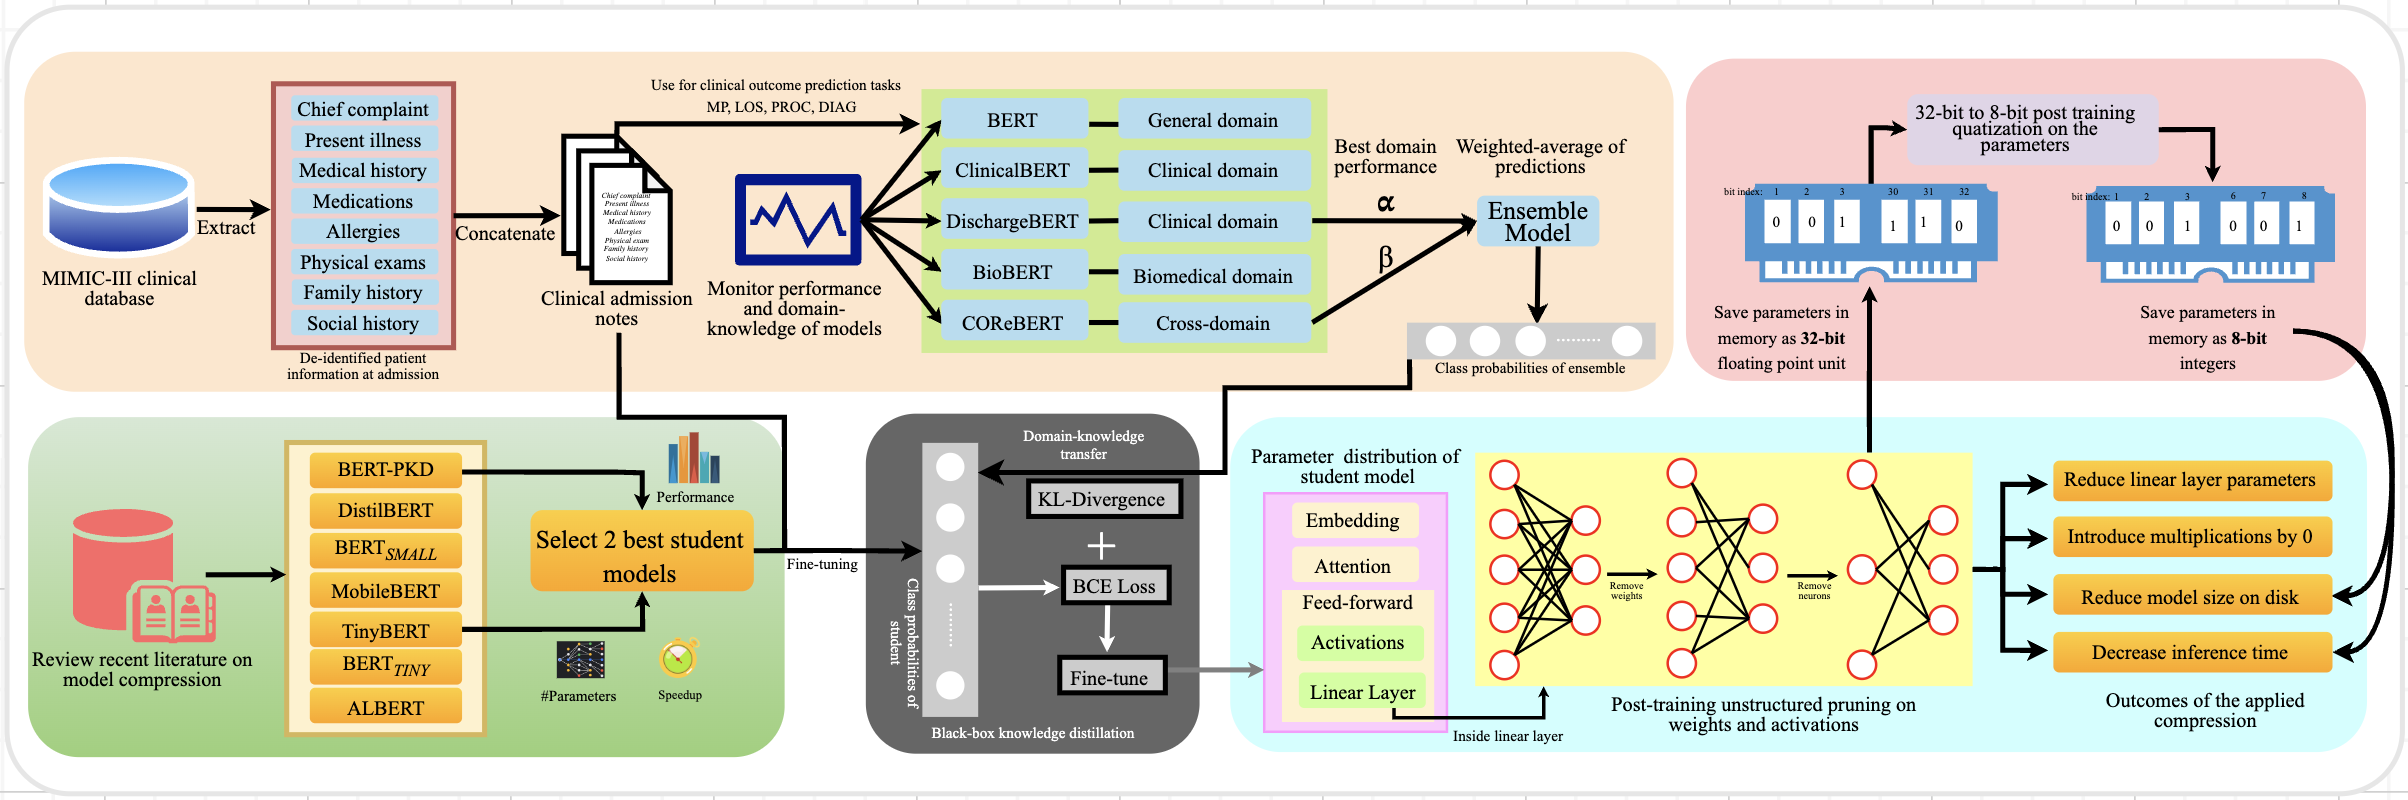
## Expected Outcomes
### By the end of this notebook, we expect to have a trained and optimized CLM capable of predicting the Length of Stay for patients in a clinical setting which is deployment-ready.
### The results will be evaluated using macro-averaged AUROC and other relevant metrics as discussed in the paper.


# Imports

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoConfig
from torch.utils.data import DataLoader
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
import os
from torch.nn import functional as F
import torch.quantization
import torch.nn.utils.prune as prune

#Set model names

In [ ]:
ensemble_name = 'ensemble(core + dischargebert)'
student_name = 'ensemble(core + dischargebert) + bert-pkd'

#Set all hyperparameters

In [ ]:
batch_size = 16
max_tokens = 512
epochs = 200
best_roc_auc = 0.0
min_delta = 0.0001
early_stopping_count = 0
early_stopping_patience = 3
gradient_accumulation_steps = 10
lr = 1e-5
temperature = 2.0
weight_decay = 0.01
num_warmup_steps = 50
pruning_ratio = 0.3
dropout_prob = 0.2

# Create the Ensemble Model

## Create the torch.nn Module

In [ ]:
class EnsembleModel(nn.Module):
    def __init__(self, model1, model2):
        super(EnsembleModel, self).__init__()
        self.model1 = model1
        self.model2 = model2

    def forward(self, input_ids, attention_mask):
        output1 = self.model1(input_ids, attention_mask=attention_mask)[0]
        output2 = self.model2(input_ids, attention_mask=attention_mask)[0]
        avg_output = (output1 + output2) / 2.00
        return avg_output

## Create Teacher Model 1 (COReBERT)

In [ ]:
# Specify the dropout rate in the configuration
config = AutoConfig.from_pretrained('bvanaken/CORe-clinical-outcome-biobert-v1',
                                    num_labels=4,
                                    hidden_dropout_prob=dropout_prob,
                                    attention_probs_dropout_prob=dropout_prob)

# Load the pre-trained model with the specified configuration
core_model = AutoModelForSequenceClassification.from_pretrained('bvanaken/CORe-clinical-outcome-biobert-v1', config=config)


## Create Teacher Model 2 (DischargeBERT)

In [ ]:
# Specify the dropout rate in the configuration
config = AutoConfig.from_pretrained('emilyalsentzer/Bio_Discharge_Summary_BERT',
                                    num_labels=4,
                                    hidden_dropout_prob=dropout_prob,
                                    attention_probs_dropout_prob=dropout_prob)

# Load the pre-trained model with the specified configuration
discharge_model = AutoModelForSequenceClassification.from_pretrained('emilyalsentzer/Bio_Discharge_Summary_BERT', config=config)

#Load the tokenizer

In [ ]:
# Choose a tokenizer
tokenizer = AutoTokenizer.from_pretrained('bvanaken/CORe-clinical-outcome-biobert-v1')

# Data Loading

In [ ]:
# Load Train, Validation, Test Dataset
train_dataset = pd.read_csv('saveDir/LOS_WEEKS_adm_train.csv')
val_dataset = pd.read_csv('saveDir/LOS_WEEKS_adm_val.csv')
test_dataset = pd.read_csv('saveDir/LOS_WEEKS_adm_test.csv')

In [ ]:
# Apply the tokenizer to the training, validation, and test datasets
train_encodings = tokenizer(train_dataset['text'].tolist(), truncation=True, padding=True, max_length = max_tokens)
val_encodings = tokenizer(val_dataset['text'].tolist(), truncation=True, padding=True,  max_length = max_tokens)
test_encodings = tokenizer(test_dataset['text'].tolist(), truncation=True, padding=True , max_length = max_tokens)

In [ ]:
# Create a Dataset for PyTorch
class LosDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = LosDataset(train_encodings, train_dataset['los_label'].tolist())
val_dataset = LosDataset(val_encodings, val_dataset['los_label'].tolist())
test_dataset = LosDataset(test_encodings, test_dataset['los_label'].tolist())

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load weights of the ensemble model into the created module

In [ ]:

# list all files in the current directory
files = os.listdir('.')

# filter the ones that start with 'CORE_baseline'
core_models = [f for f in files if f.startswith(ensemble_name)]

if core_models:
    print("Found models:")
    for model in core_models:
        print(model)

    # get the first (and supposedly only) model
    model_path = core_models[0]
    state_dict = torch.load(model_path)
    # Remove specific keys
    keys_to_remove = ["model1.bert.embeddings.position_ids", "model2.bert.embeddings.position_ids"]
    for key in keys_to_remove:
        if key in state_dict:
            del state_dict[key]

    # Now load the modified state dict into your model
    ensemble_model.load_state_dict(state_dict)
    print(f"Loaded Model: {model_path}")
else:
    print("No models found with the given name.")

In [ ]:
# Push the model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ensemble_model = ensemble_model.to(device)

# Create the student model

In [ ]:
from transformers import AutoConfig, AutoModelForSequenceClassification

# Specify the dropout rate in the configuration for BERT-PKD
config = AutoConfig.from_pretrained('bert-pkd-6',
                                    num_labels=4,
                                    hidden_dropout_prob=dropout_prob,
                                    attention_probs_dropout_prob=dropout_prob)

# Load the pre-trained BERT-PKD model with the specified configuration
bert_pkd_model = AutoModelForSequenceClassification.from_pretrained('bert-pkd-6', config=config)


# Load weights of the student model (if available)

In [ ]:
# list all files in the current directory
files = os.listdir('.')

# filter the ones that start with 'CORE_baseline'
core_models = [f for f in files if f.startswith(student_name)]

if core_models:
    print("Found models:")
    for model in core_models:
        print(model)

    # get the first (and supposedly only) model
    model_path = core_models[0]

    # load the model state
    student_model.load_state_dict(torch.load(model_path))
    print(f"Loaded Model: {model_path}")
else:
    print("No models found starting with given name.")

In [ ]:
# Push the model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student_model = student_model.to(device)

# Prepare Optimizer and Scheduler for training

In [ ]:
# Set the optimizer
optimizer = AdamW(student_model.parameters(), lr=lr, weight_decay=weight_decay)

# Set the scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=len(train_loader) * epochs // gradient_accumulation_steps
)

# Training

In [ ]:
# Training
for epoch in range(epochs):
    student_model.train()
    train_loss = 0
    for step, batch in enumerate(tqdm(train_loader)):
        optimizer.zero_grad() if step % gradient_accumulation_steps == 0 else None
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # get student model's logits
        student_logits = student_model(input_ids, attention_mask)[0]

        # get teacher model's logits
        with torch.no_grad():
            teacher_logits = ensemble_model(input_ids, attention_mask)


        # calculate loss
        loss = (
            nn.KLDivLoss()(F.log_softmax(student_logits/temperature, dim=1),
                           F.softmax(teacher_logits/temperature, dim=1)) * (temperature ** 2) +
            nn.CrossEntropyLoss()(student_logits, labels)
        )

        (loss / gradient_accumulation_steps).backward()

        train_loss += loss.item()

        if (step + 1) % gradient_accumulation_steps == 0 or (step + 1) == len(train_loader):
            optimizer.step()
            scheduler.step()

    student_model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for batch in tqdm(val_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = student_model(input_ids, attention_mask)[0]
            loss = nn.CrossEntropyLoss()(outputs, labels)
            val_loss += loss.item()
            val_preds.append(F.softmax(outputs, dim=1).cpu().numpy())
            val_labels.append(labels.cpu().numpy())


    val_preds = np.concatenate(val_preds)
    val_labels = np.concatenate(val_labels)
    val_loss /= len(val_loader)
    train_loss /= len(train_loader)
    print(f'Epoch: {epoch+1}/{epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}')

    # Calculate metrics
    val_preds_class = np.argmax(val_preds, axis=1)
    accuracy = accuracy_score(val_labels, val_preds_class)
    recall = recall_score(val_labels, val_preds_class, average='weighted')
    precision = precision_score(val_labels, val_preds_class, average='weighted')
    f1 = f1_score(val_labels, val_preds_class, average='weighted')
    micro_f1 = f1_score(val_labels, val_preds_class, average='micro')
    macro_roc_auc = roc_auc_score(val_labels, val_preds, multi_class='ovo', average='macro')

    print(f'Accuracy: {accuracy}, Recall: {recall}, Precision: {precision}, F1: {f1}, Micro F1: {micro_f1}, Macro Roc Auc: {macro_roc_auc}')


    # Implement early stopping
    if macro_roc_auc - best_roc_auc < min_delta:
        early_stopping_count += 1
        print(f'EarlyStopping counter: {early_stopping_count} out of {early_stopping_patience}')
        if early_stopping_count >= early_stopping_patience:
            print('Early stopping')
            break
    else:
        best_roc_auc = macro_roc_auc
        early_stopping_count = 0
        torch.save(student_model.state_dict(), f"{student_name}_epoch_{epoch}roc_{best_roc_auc}.pth")

# Load model after training is complete

In [ ]:
# list all files in the current directory
files = os.listdir('.')

# filter the ones that start with 'CORE_baseline'
core_models = [f for f in files if f.startswith(student_name)]

if core_models:
    print("Found models:")
    for model in core_models:
        print(model)

    # get the first (and supposedly only) model
    model_path = core_models[0]

    # load the model state
    student_model.load_state_dict(torch.load(model_path))
    print("Loaded Model")
else:
    print("No models found starting with the given name.")

# Evaluate the distilled student model on CPU

In [ ]:
student_model.to('cpu')
device = 'cpu'

# Put the model in evaluation mode
student_model.eval()

test_preds = []
test_labels = []

# Iterate over test data
with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = student_model(input_ids, attention_mask)[0]
        test_preds.append(F.softmax(outputs, dim=1).cpu().numpy())
        test_labels.append(labels.cpu().numpy())


In [ ]:
test_preds = np.concatenate(test_preds)
test_labels = np.concatenate(test_labels)

# Calculate metrics
test_preds_class = np.argmax(test_preds, axis=1)
accuracy = accuracy_score(test_labels, test_preds_class)
recall = recall_score(test_labels, test_preds_class, average='weighted')
precision = precision_score(test_labels, test_preds_class, average='weighted')
f1 = f1_score(test_labels, test_preds_class, average='weighted')
micro_f1 = f1_score(test_labels, test_preds_class, average='micro')
macro_roc_auc = roc_auc_score(test_labels, test_preds, multi_class='ovo', average='macro')

print(f'Accuracy: {accuracy}, Recall: {recall}, Precision: {precision}, F1: {f1}, Micro F1: {micro_f1}, Macro Roc Auc: {macro_roc_auc}')

# Apply Pruning to the distilled student model

In [ ]:
def prune_attention(module, amount):
    """
    Prune the attention heads of the model
    """
    # Prune the query, key, value, and output dense layers
    for name in ['query', 'key', 'value', 'dense']:
        layer = getattr(module, name)
        prune.l1_unstructured(layer, name='weight', amount=amount)
        if layer.bias is not None:
            prune.l1_unstructured(layer, name='bias', amount=amount)

def prune_model(model, pruning_rate=pruning_ratio):
    """
    Apply unstructured pruning to various layers of the BERT model
    """
    # Iterate over all modules in the model
    for module in model.modules():
        # Prune Linear layers
        if isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=pruning_rate)
            if module.bias is not None:
                prune.l1_unstructured(module, name='bias', amount=pruning_rate)
        # Prune attention heads
        elif isinstance(module, transformers.models.bert.modeling_bert.BertSelfAttention):
            prune_attention(module, pruning_rate)

model = student_model

# Prune the model
prune_model(model)

# Remove pruning re-parametrization for cleaner model saving
for module in model.modules():
    if isinstance(module, torch.nn.Linear) or isinstance(module, transformers.models.bert.modeling_bert.BertSelfAttention):
        prune.remove(module, 'weight')
        if module.bias is not None:
            prune.remove(module, 'bias')

# Evaluate the distilled and pruned model

In [ ]:
from torch.nn import functional as F
import torch.quantization

student_model = model

student_model.to('cpu')
device = 'cpu'

# Put the model in evaluation mode
student_model.eval()

# Initialize lists to store predictions and true labels
test_preds = []
test_labels = []

# Iterate over test data
with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = student_model(input_ids, attention_mask)[0]
        test_preds.append(F.softmax(outputs, dim=1).cpu().numpy())
        test_labels.append(labels.cpu().numpy())

In [ ]:
test_preds = np.concatenate(test_preds)
test_labels = np.concatenate(test_labels)

# Calculate metrics
test_preds_class = np.argmax(test_preds, axis=1)
accuracy = accuracy_score(test_labels, test_preds_class)
recall = recall_score(test_labels, test_preds_class, average='weighted')
precision = precision_score(test_labels, test_preds_class, average='weighted')
f1 = f1_score(test_labels, test_preds_class, average='weighted')
micro_f1 = f1_score(test_labels, test_preds_class, average='micro')
macro_roc_auc = roc_auc_score(test_labels, test_preds, multi_class='ovo', average='macro')

print(f'Accuracy: {accuracy}, Recall: {recall}, Precision: {precision}, F1: {f1}, Micro F1: {micro_f1}, Macro Roc Auc: {macro_roc_auc}')

# Apply quantization to the pruned model

In [ ]:
from torch.nn import functional as F
import torch.quantization

student_model.to('cpu')
device = 'cpu'

# Put the model in evaluation mode
student_model.eval()

# Apply dynamic quantization
quantized_student_model = torch.quantization.quantize_dynamic(
    student_model,
    {nn.Linear},  # Specify which layers to quantize
    dtype=torch.qint8  # Specify the quantization dtype
)


# Evaluate model after quantization

In [ ]:
# Initialize lists to store predictions and true labels
test_preds = []
test_labels = []

# Iterate over test data
with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = quantized_student_model(input_ids, attention_mask)[0]
        test_preds.append(F.softmax(outputs, dim=1).cpu().numpy())
        test_labels.append(labels.cpu().numpy())

In [ ]:
test_preds = np.concatenate(test_preds)
test_labels = np.concatenate(test_labels)

# Calculate metrics
test_preds_class = np.argmax(test_preds, axis=1)
accuracy = accuracy_score(test_labels, test_preds_class)
recall = recall_score(test_labels, test_preds_class, average='weighted')
precision = precision_score(test_labels, test_preds_class, average='weighted')
f1 = f1_score(test_labels, test_preds_class, average='weighted')
micro_f1 = f1_score(test_labels, test_preds_class, average='micro')
macro_roc_auc = roc_auc_score(test_labels, test_preds, multi_class='ovo', average='macro')

print(f'Accuracy: {accuracy}, Recall: {recall}, Precision: {precision}, F1: {f1}, Micro F1: {micro_f1}, Macro Roc Auc: {macro_roc_auc}')